**커스텀 데이터와 커스텀 전처리 사용하기**

In [43]:
import torch
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

In [44]:
# 32x32 컬러 이미지와 라벨이 각각 100장이 있다고 가정하다.
# glob -> PIL, openCV ..
train_images = np.random.randint(256,size=(100,32,32,3))/255 # (이미지 수)x(너비)x(높이)x(채널 수)
train_labels = np.random.randint(2,size=(100,1)) # 라벨 수

In [45]:
# 텐서 변환 전처리 클래스
# 텐서 변환 후 학습에 맞는 크기로 변환
class ToTensor:
    def __call__(self, sample):
        inputs, labels = sample
        inputs = torch.FloatTensor(inputs)
        inputs = inputs.permute(2,0,1)  # call 함수는 입력값을 하나씩 불러오기 때문에, premute(0,3,1,2) 대신 이 코드 사용
        return inputs, torch.LongTensor(labels)

In [46]:
# 선형식
class LinearTensor:

    def __init__(self, slope=1, bias=0):
        self.slope = slope
        self.bias = bias

    def __call__(self, sample):
        inputs, labels = sample
        inputs = self.slope*inputs + self.bias # ax+b 계산하기
        return inputs, labels

In [54]:
# CutOut 전처리 클래스
# 이미지 내부에 무작위로 사각형 영역 선택 --> 0으로 만든다(데이터 증식)
class CutOut:
    def __init__(self, ratio=.5):
        self.ratio = int(1/ratio)

    def __call__(self, sample):
        inputs, labels = sample
        active = int(np.random.randint(0, self.ratio, 1))  # ratio가 50% --> 0(컷아웃 발현)과 1(원본 그대로 내보내) 중 하나만 발현

        if active == 0:
            _, w, h = inputs.size()  ## 이미지 높이, 너비 받아
            min_len = min(w, h)      # 최솟값 계산
            box_size = int(min_len//4)   # cutout 크기 = 길이 최솟값의 25%로 지정한다!!
            idx = int(np.random.randint(0, min_len-box_size, 1))  # cutout 박스의 좌측 상단 꼭지점 위치 지정
            inputs[:,idx:idx+box_size, idx:idx+box_size] = 0    # 해당 정사각형 영역 to 0

        return inputs, labels

앞에서 배운 MyDataset에 transform=None 추가

In [55]:
# 앞에서 사용한 양식을 그대로 사용하되 전처리 작업을 할 수 있도록 transform을 추가한다.
class MyDataset(Dataset):

    def __init__(self, x_data, y_data, transform=None):

        self.x_data = x_data # 넘파이 배열이 들어온다.
        self.y_data = y_data # 넘파이 배열이 들어온다.
        self.transform = transform
        self.len = len(y_data)
        self.tensor = ToTensor()

    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]

        if self.transform:
            sample = self.transform(sample) #self.transform이 None이 아니라면 전처리를 작업한다.
        else:
            sample = self.tensor(sample)

        return sample

    def __len__(self):
        return self.len

In [56]:
#trans = tr.Compose([ToTensor(),LinearTensor(2,5)]) # 텐서 변환 후 선형식 2x+5 연산
trans = tr.Compose([ToTensor(),CutOut()])
dataset1 = MyDataset(train_images,train_labels, transform=trans)
train_loader1 = DataLoader(dataset1, batch_size=10, shuffle=True)


# ToTensor()와 tr.ToTensor()의 차이
# 앞 서 사용한 tr.ToTensor()는 import torchvision.transforms as tr를 이용한 파이토치 메소드를 이용한 것이고
# ToTensor()는 위에서 정의 된 메소드를 사용한 것이다.

In [57]:
images1, labels1 = next(iter(train_loader1))
print(images1.size()) # 배치 및 이미지 크기 확인

torch.Size([10, 3, 32, 32])


In [60]:
import torchvision
def imshow(img):
    plt.figure(figsize=(10,100))
    plt.imshow(img.permute(1,2,0).numpy()) # 그림 그리기 위해 이미지 크기 배열 변경(채널수, 너비, 높이 --> 너비, 높이, 채널 수)
    plt.show()

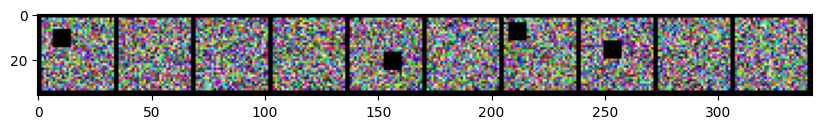

In [61]:
imshow(torchvision.utils.make_grid(images1,nrow=10))

# 무작위로 적용된 CutOut 이미지

# 커스텀 데이터와 파이토치 제공 전처리 사용하기

In [65]:
# 텐서 변환과 같은 전처리는 파이토치 제공 전처리 사용 시 편리
# but PILImage일 경우 사용할 수 있다
class MyTransform:
    def __call__(self, sample):
        inputs, labels = sample
        inputs = torch.FloatTensor(inputs)
        inputs = inputs.permute(2,0,1)
        labels = torch.FloatTensor(labels)

        transf = tr.Compose([tr.ToPILImage(), tr.Resize(128), tr.ToTensor()])       # ToPILImage로 이미지 타입 변경
        final_output = transf(inputs)  # 불러온 샘플을 전처리에 넣는다

        return final_output, labels

In [66]:
# 데이터 불러오기
dataset2 = MyDataset(train_images,train_labels, transform=MyTransform())
train_loader2 = DataLoader(dataset2, batch_size=10, shuffle=True)

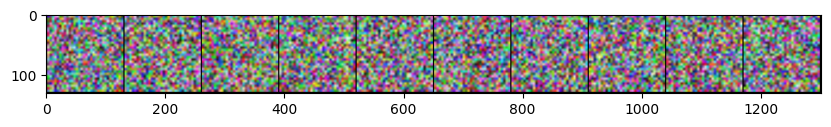

torch.Size([10, 3, 128, 128])


In [67]:
images2, labels2 = next(iter(train_loader2))
imshow(torchvision.utils.make_grid(images2,nrow=10))
print(images2.size()) # 배치 및 이미지 크기 확인

# 커스텀 전처리와 파이토치에서 제공하는 전처리 함께 사용하기

In [69]:
# 앞에서 배운 CutOut과 달리 라벨 받지 X, 이미지만 받아
# Compose 내부에 제공된 전처리는 이미지만 받아서 처리하기 때문에 양식을 맞춰 주어야 하기 때문!!
class CutOut:

    def __init__(self, ratio=.5):
        self.ratio = int(1/ratio)

    def __call__(self, inputs):

        active = int(np.random.randint(0, self.ratio, 1))

        if active == 0:
            _, w, h = inputs.size()
            min_len = min(w, h)
            box_size = int(min_len//4)
            idx = int(np.random.randint(0, min_len-box_size, 1))
            inputs[:,idx:idx+box_size,idx:idx+box_size] = 0

        return inputs

In [70]:
# 3.3에서 사용한 양식을 그대로 사용하되 전처리 작업을 할 수 있도록 transform을 추가한다.
class MyDataset(Dataset):

    def __init__(self, x_data, y_data, transform=None):

        self.x_data = x_data # 넘파이 배열이 들어온다.
        self.y_data = y_data # 넘파이 배열이 들어온다.
        self.transform = transform
        self.len = len(y_data)
        self.tensor = ToTensor()

    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]

        if self.transform:
            sample = self.transform(sample) #self.transform이 None이 아니라면 전처리를 작업한다.
        else:
            sample = self.tensor(sample)

        return sample

    def __len__(self):
        return self.len

In [71]:
class MyTransform:

    def __call__(self, sample):
        inputs, labels = sample
        inputs = torch.FloatTensor(inputs)
        inputs = inputs.permute(2,0,1)
        labels = torch.FloatTensor(labels)

        transf = tr.Compose([tr.ToPILImage(), tr.Resize(128), tr.ToTensor(), CutOut()])
        final_output = transf(inputs)

        return final_output, labels

전처리 적용 O

In [72]:
dataset3 = MyDataset(train_images,train_labels, transform=MyTransform())
train_loader3 = DataLoader(dataset3, batch_size=10, shuffle=True)

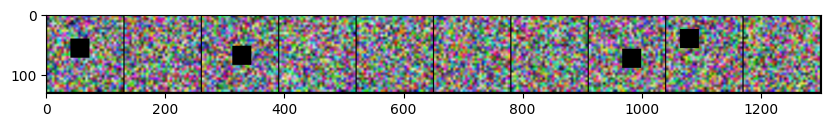

torch.Size([10, 3, 128, 128])


In [74]:
images3, labels3 = next(iter(train_loader3))
imshow(torchvision.utils.make_grid(images3,nrow=10))
print(images3.size()) # 배치 및 이미지 크기 확인

전처리 적용 X

In [75]:
dataset3 = MyDataset(train_images,train_labels)
train_loader3 = DataLoader(dataset3, batch_size=10, shuffle=True)

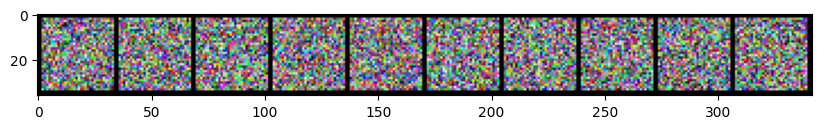

torch.Size([10, 3, 32, 32])


In [77]:
images3, labels3 = next(iter(train_loader3))
imshow(torchvision.utils.make_grid(images3,nrow=10))
print(images3.size()) # 배치 및 이미지 크기 확인

CIFAR 100 데이터와 커스텀 전처리 사용

In [78]:
transf = tr.Compose([tr.Resize(128), tr.ToTensor(), CutOut()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transf)

100%|██████████| 170498071/170498071 [00:04<00:00, 41259982.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


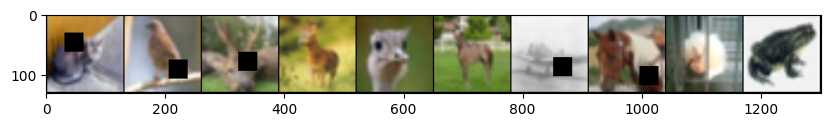

torch.Size([10, 3, 128, 128])


In [80]:
trainloader = DataLoader(trainset, batch_size=10, shuffle=True)
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images,nrow=10))
print(images.size()) # 배치 및 이미지 크기 확인